In [ ]:
!pip install google_play_scraper
!pip install textblob
!pip install seaborn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 1.4 MB/s eta 0:00:00


In [ ]:
from google_play_scraper import app
import pandas as pd
import numpy as np
import sklearn
import requests
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import seaborn as sns
import textblob
#from wordcloud import WordCloud
from pathlib import Path
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report, accuracy_score

import pickle
import re
import time
import datetime                              # access to %%time, for timing individual notebook cells
import os
from PIL import Image
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

%matplotlib inline
%config InlineBackend.figure_format='retina'

# Import seaborn styles explicitly
import seaborn as sns
# Apply the seaborn style before creating plots
sns.set_style("whitegrid")  # This line sets the Seaborn style

plt.rcParams["figure.figsize"] = (15,10)

In [ ]:
from google_play_scraper import app, Sort, reviews_all

mt_reviews = reviews_all(
    'com.goquo.jt.app',
    sleep_milliseconds=0, # defaults to 0
    lang='en', # defaults to 'en'
    sort=Sort.NEWEST, # defaults to Sort.MOST_RELEVANT
)

In [ ]:
df_mtrev = pd.DataFrame(np.array(mt_reviews),columns=['content'])
df_mtrev = df_mtrev.join(pd.DataFrame(df_mtrev.pop('content').tolist()))
df_mtrev.to_csv(r'df_mtrev', index=False)

In [ ]:
df_mtrev

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion
0,557dde96-5a4b-4ebf-9b67-74cfb24e7bcc,Ruslan Seniuk,https://play-lh.googleusercontent.com/a/ACg8oc...,constantly error when trying to book ticket vi...,1,0,4.7,2025-09-20 14:06:57,None,NaT,4.7
1,55405e67-3a24-4c6d-9bce-714f6b2c5fd5,candra yulianto,https://play-lh.googleusercontent.com/a-/ALV-U...,Nice,5,0,4.7,2025-09-13 09:16:32,None,NaT,4.7
2,282cb0a2-449e-43c0-b91e-aa57821786a5,Vikrant Minhas,https://play-lh.googleusercontent.com/a-/ALV-U...,I cannot enter the existing booking in the app...,1,0,4.7,2025-08-28 02:15:16,None,NaT,4.7
3,863f6723-077c-4186-94f7-5f7e80bd2b81,alizan aziz,https://play-lh.googleusercontent.com/a-/ALV-U...,so poor app,1,0,4.7,2025-08-26 04:10:02,None,NaT,4.7
4,176e22eb-3b93-49ae-97e6-ed57b3a55bca,Devinder Singh,https://play-lh.googleusercontent.com/a-/ALV-U...,I have book flight why crate paravlom,5,0,4.7,2025-08-18 13:25:45,None,NaT,4.7
...,...,...,...,...,...,...,...,...,...,...,...
793,afb0992e-c368-47b0-bfea-492a8486fb6c,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,Good enough,4,0,1.1.1,2014-11-16 04:44:31,None,NaT,1.1.1
794,a2f77ddb-ff54-4f27-bdf1-d1e94fa3d431,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,Excellent ! Friendly user,5,0,1.1.1,2014-11-15 07:55:37,None,NaT,1.1.1
795,764f640d-e28f-4dbe-ad83-459814558972,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,Coolll,5,0,None,2014-11-11 07:56:10,None,NaT,None
796,29a8a041-e674-443a-8227-3fee0dad8cbb,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,Maaf sebelumnya... saya pelaggan setia lion ai...,1,0,1.1.1,2014-11-11 02:52:52,None,NaT,1.1.1


In [ ]:
#We do not need data for column reviewId, userName, userImage so
#we will show only these column
df_mtrev.loc[:,["content","score","thumbsUpCount", "reviewCreatedVersion", "at", "replyContent", "repliedAt"]]

,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt
0,constantly error when trying to book ticket vi...,1,0,4.7,2025-09-20 14:06:57,None,NaT
1,Nice,5,0,4.7,2025-09-13 09:16:32,None,NaT
2,I cannot enter the existing booking in the app...,1,0,4.7,2025-08-28 02:15:16,None,NaT
3,so poor app,1,0,4.7,2025-08-26 04:10:02,None,NaT
4,I have book flight why crate paravlom,5,0,4.7,2025-08-18 13:25:45,None,NaT
...,...,...,...,...,...,...,...
793,Good enough,4,0,1.1.1,2014-11-16 04:44:31,None,NaT
794,Excellent ! Friendly user,5,0,1.1.1,2014-11-15 07:55:37,None,NaT
795,Coolll,5,0,None,2014-11-11 07:56:10,None,NaT
796,Maaf sebelumnya... saya pelaggan setia lion ai...,1,0,1.1.1,2014-11-11 02:52:52,None,NaT


In [ ]:
#Check number of reviews scores
df_mtrev['score'].value_counts()

,count
score,
1,497
5,184
4,43
2,40
3,34


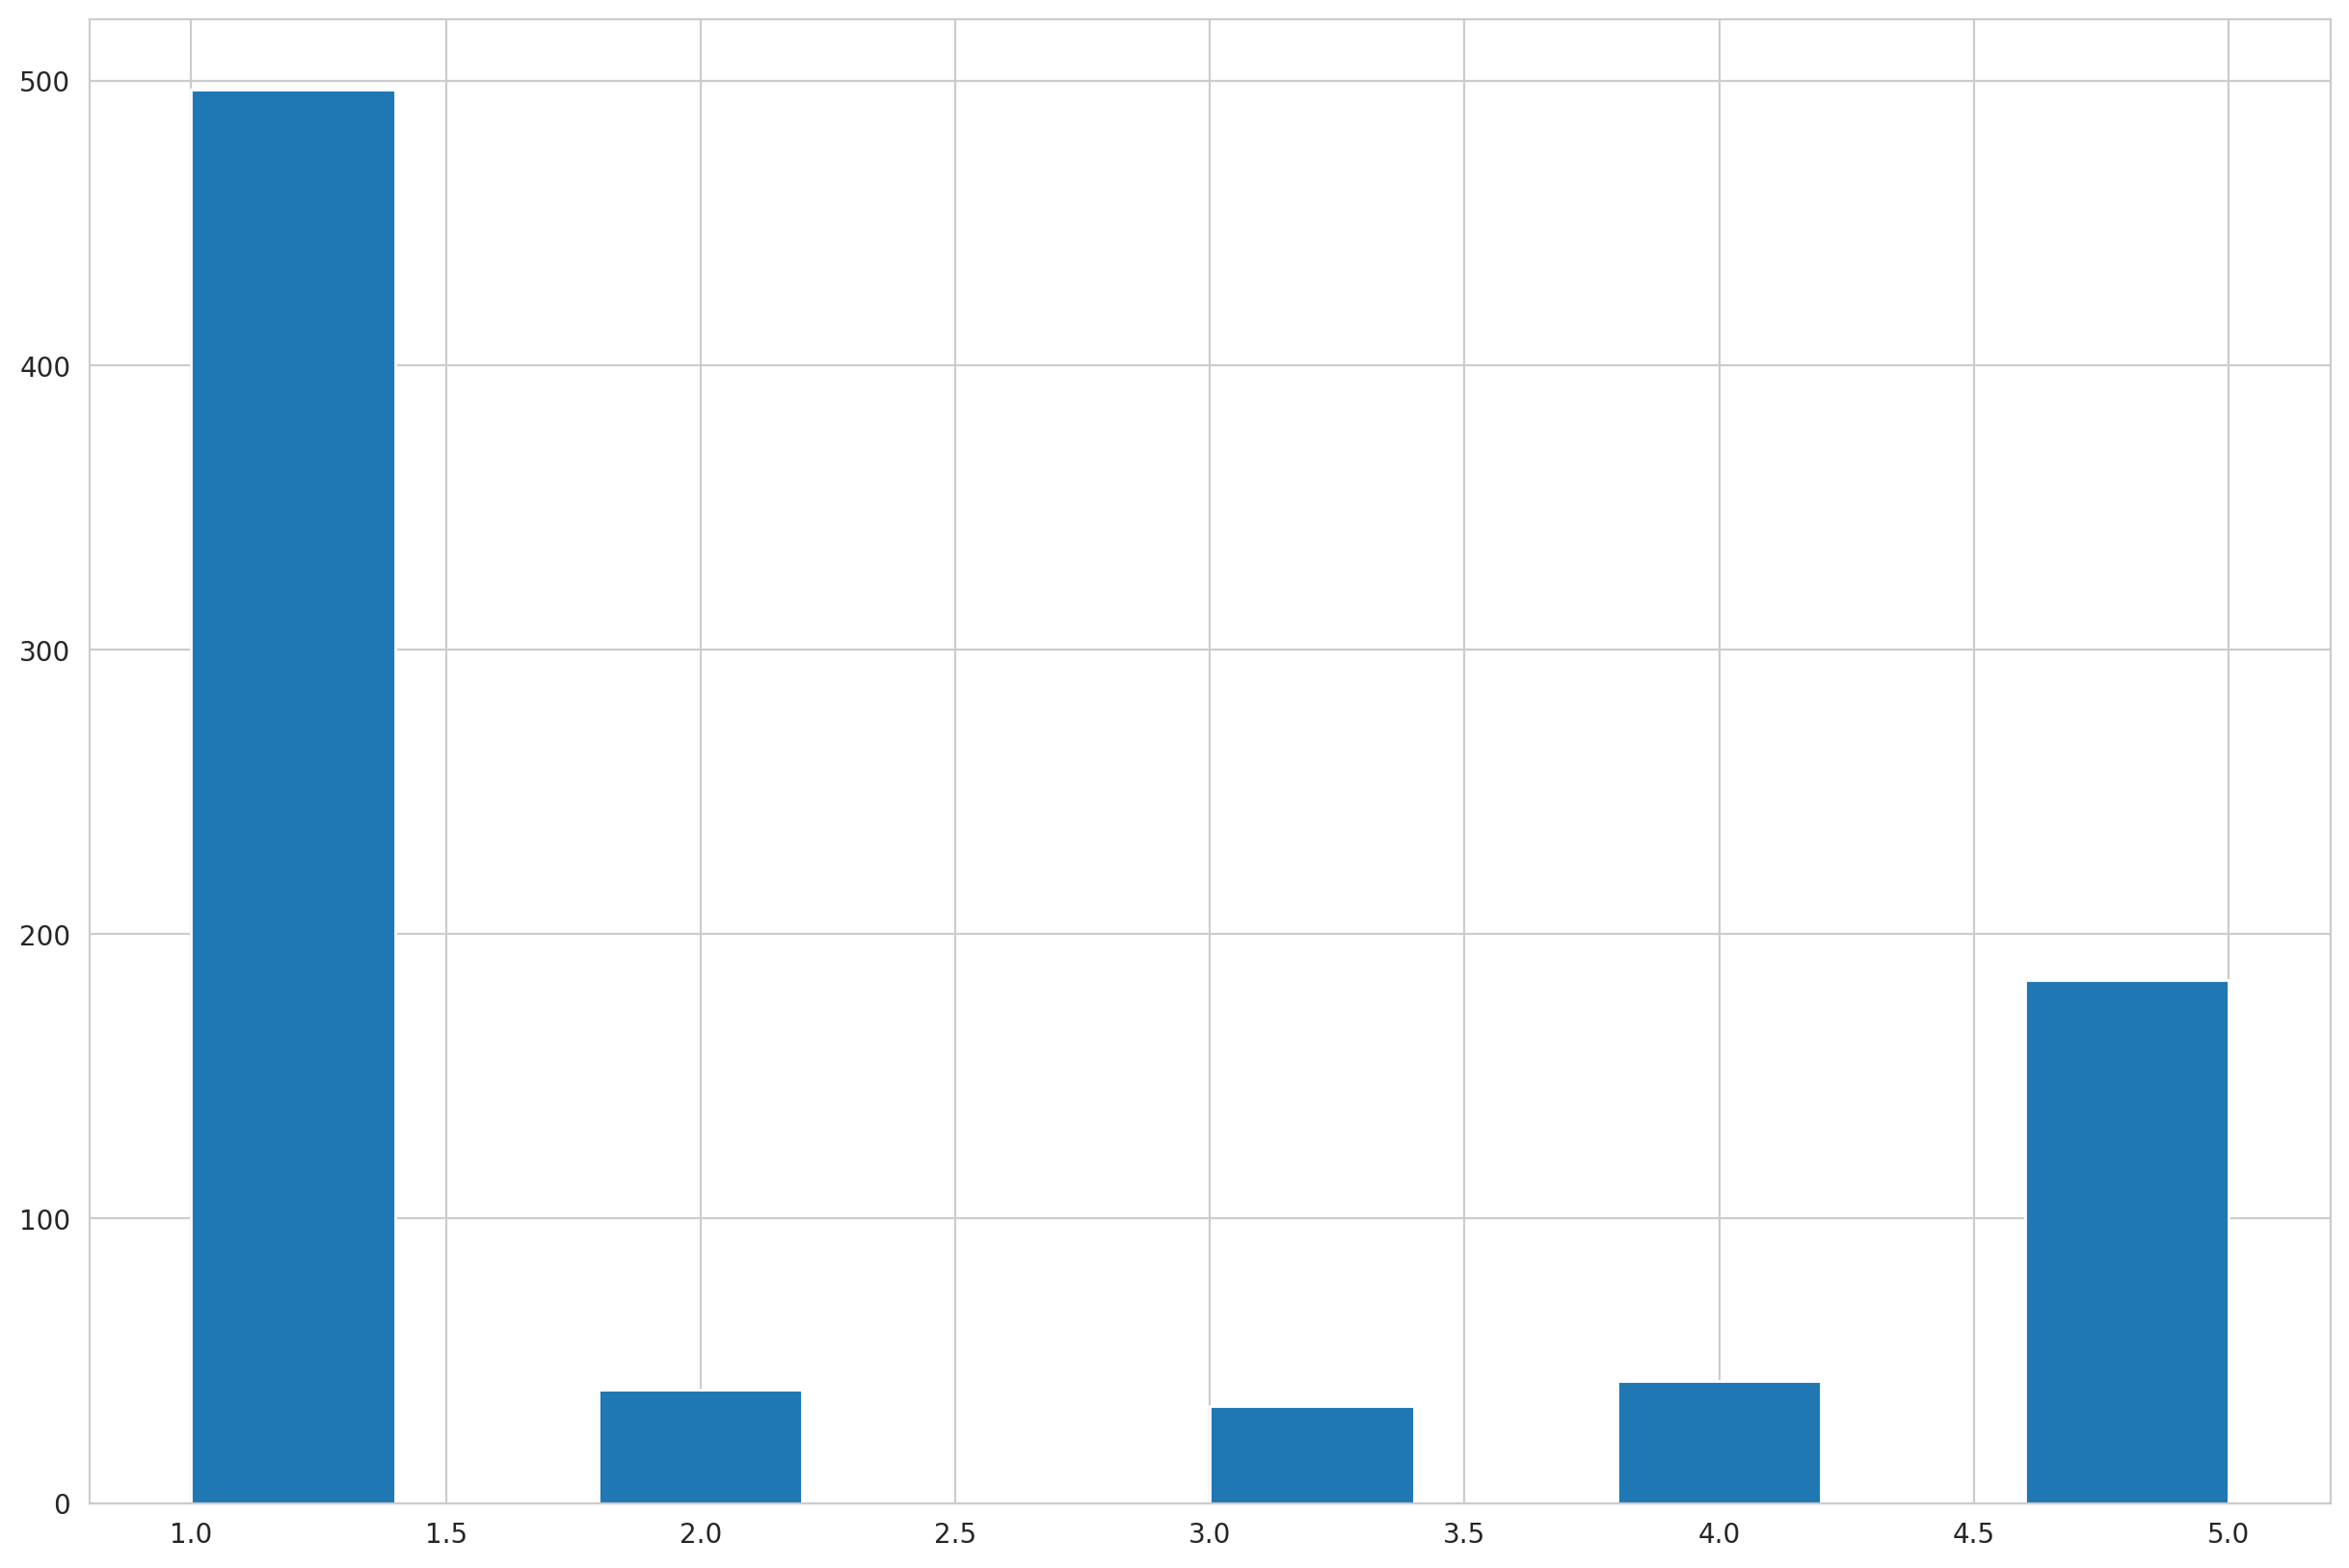

In [ ]:
plt.hist(df_mtrev['score'])
plt.show()

In [ ]:
!pip install emoji

import numpy as np
import pandas as pd
pd.set_option("display.max_colwidth", 200)
#from pandas_profiling import ProfileReport
import regex
import nltk
import wordcloud
import textblob

from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from wordcloud import WordCloud, STOPWORDS
from textblob import TextBlob

import string
import re
import emoji

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 608.4/608.4 kB 5.5 MB/s eta 0:00:00


In [ ]:
#Creating polarity on the column: content (review from the apps) using TextBlob
#Read https://textblob.readthedocs.io/en/dev/quickstart.html

from textblob import TextBlob
# Handle None values in 'content' column by replacing them with empty strings
df_mtrev['sentiment_polarity'] = df_mtrev['content'].astype(str).apply(lambda x: TextBlob(x).polarity)
df_mtrev['sentiment_subjective'] = df_mtrev['content'].astype(str).apply(lambda x: TextBlob(x).subjectivity)

In [ ]:
df_mtrev.loc[:,["content","score","sentiment_polarity", "sentiment_subjective"]]

,content,score,sentiment_polarity,sentiment_subjective
0,constantly error when trying to book ticket via app,1,0.000000,0.333333
1,Nice,5,0.600000,1.000000
2,I cannot enter the existing booking in the app. Cannot create an account.,1,0.000000,0.000000
3,so poor app,1,-0.400000,0.600000
4,I have book flight why crate paravlom,5,0.000000,0.000000
...,...,...,...,...
793,Good enough,4,0.350000,0.550000
794,Excellent ! Friendly user,5,0.687500,0.750000
795,Coolll,5,0.000000,0.000000
796,"Maaf sebelumnya... saya pelaggan setia lion air, aplikasi ini memangbcukup membantu dalam pesan ticket lion air.. cuma yang membuat saya kecewa adalah ketika pesan ticket dari tujuan tertentu ke t...",1,0.000000,0.000000


## Lowercasing

In [ ]:
#DATA PREPROCESSING
# Lower casing
# Change the reviews type to string
df_mtrev['content'] = df_mtrev['content'].astype(str)# Before lowercasing
# Before lowercasing
print(df_mtrev['content'][188])
print(df_mtrev['content'][1])
print(df_mtrev['content'][500])

Bogus airline , didn't send itinerary Bogus app
Nice
Stars


In [ ]:
#Lowercase all reviews to see the difference
df_mtrev['content']= df_mtrev['content'].apply(lambda x: x.lower())
print(df_mtrev['content'][188])
print(df_mtrev['content'][1])
print(df_mtrev['content'][500])

bogus airline , didn't send itinerary bogus app
nice
stars


##Stopwords Removal
Indonesian Stopwords

In [ ]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

# Get Indonesian stopwords
indonesian_stopwords = stopwords.words('indonesian')

# Display first 20 stopwords
print(indonesian_stopwords[:20])

['ada', 'adalah', 'adanya', 'adapun', 'agak', 'agaknya', 'agar', 'akan', 'akankah', 'akhir', 'akhiri', 'akhirnya', 'aku', 'akulah', 'amat', 'amatlah', 'anda', 'andalah', 'antar', 'antara']


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
print(len(indonesian_stopwords))

758


,Word,Frequency
0,to,188
1,the,154
2,in,135
3,app,118
4,and,117
...,...,...
95,uninstall,13
96,browser,13
97,error,12
98,don't,12


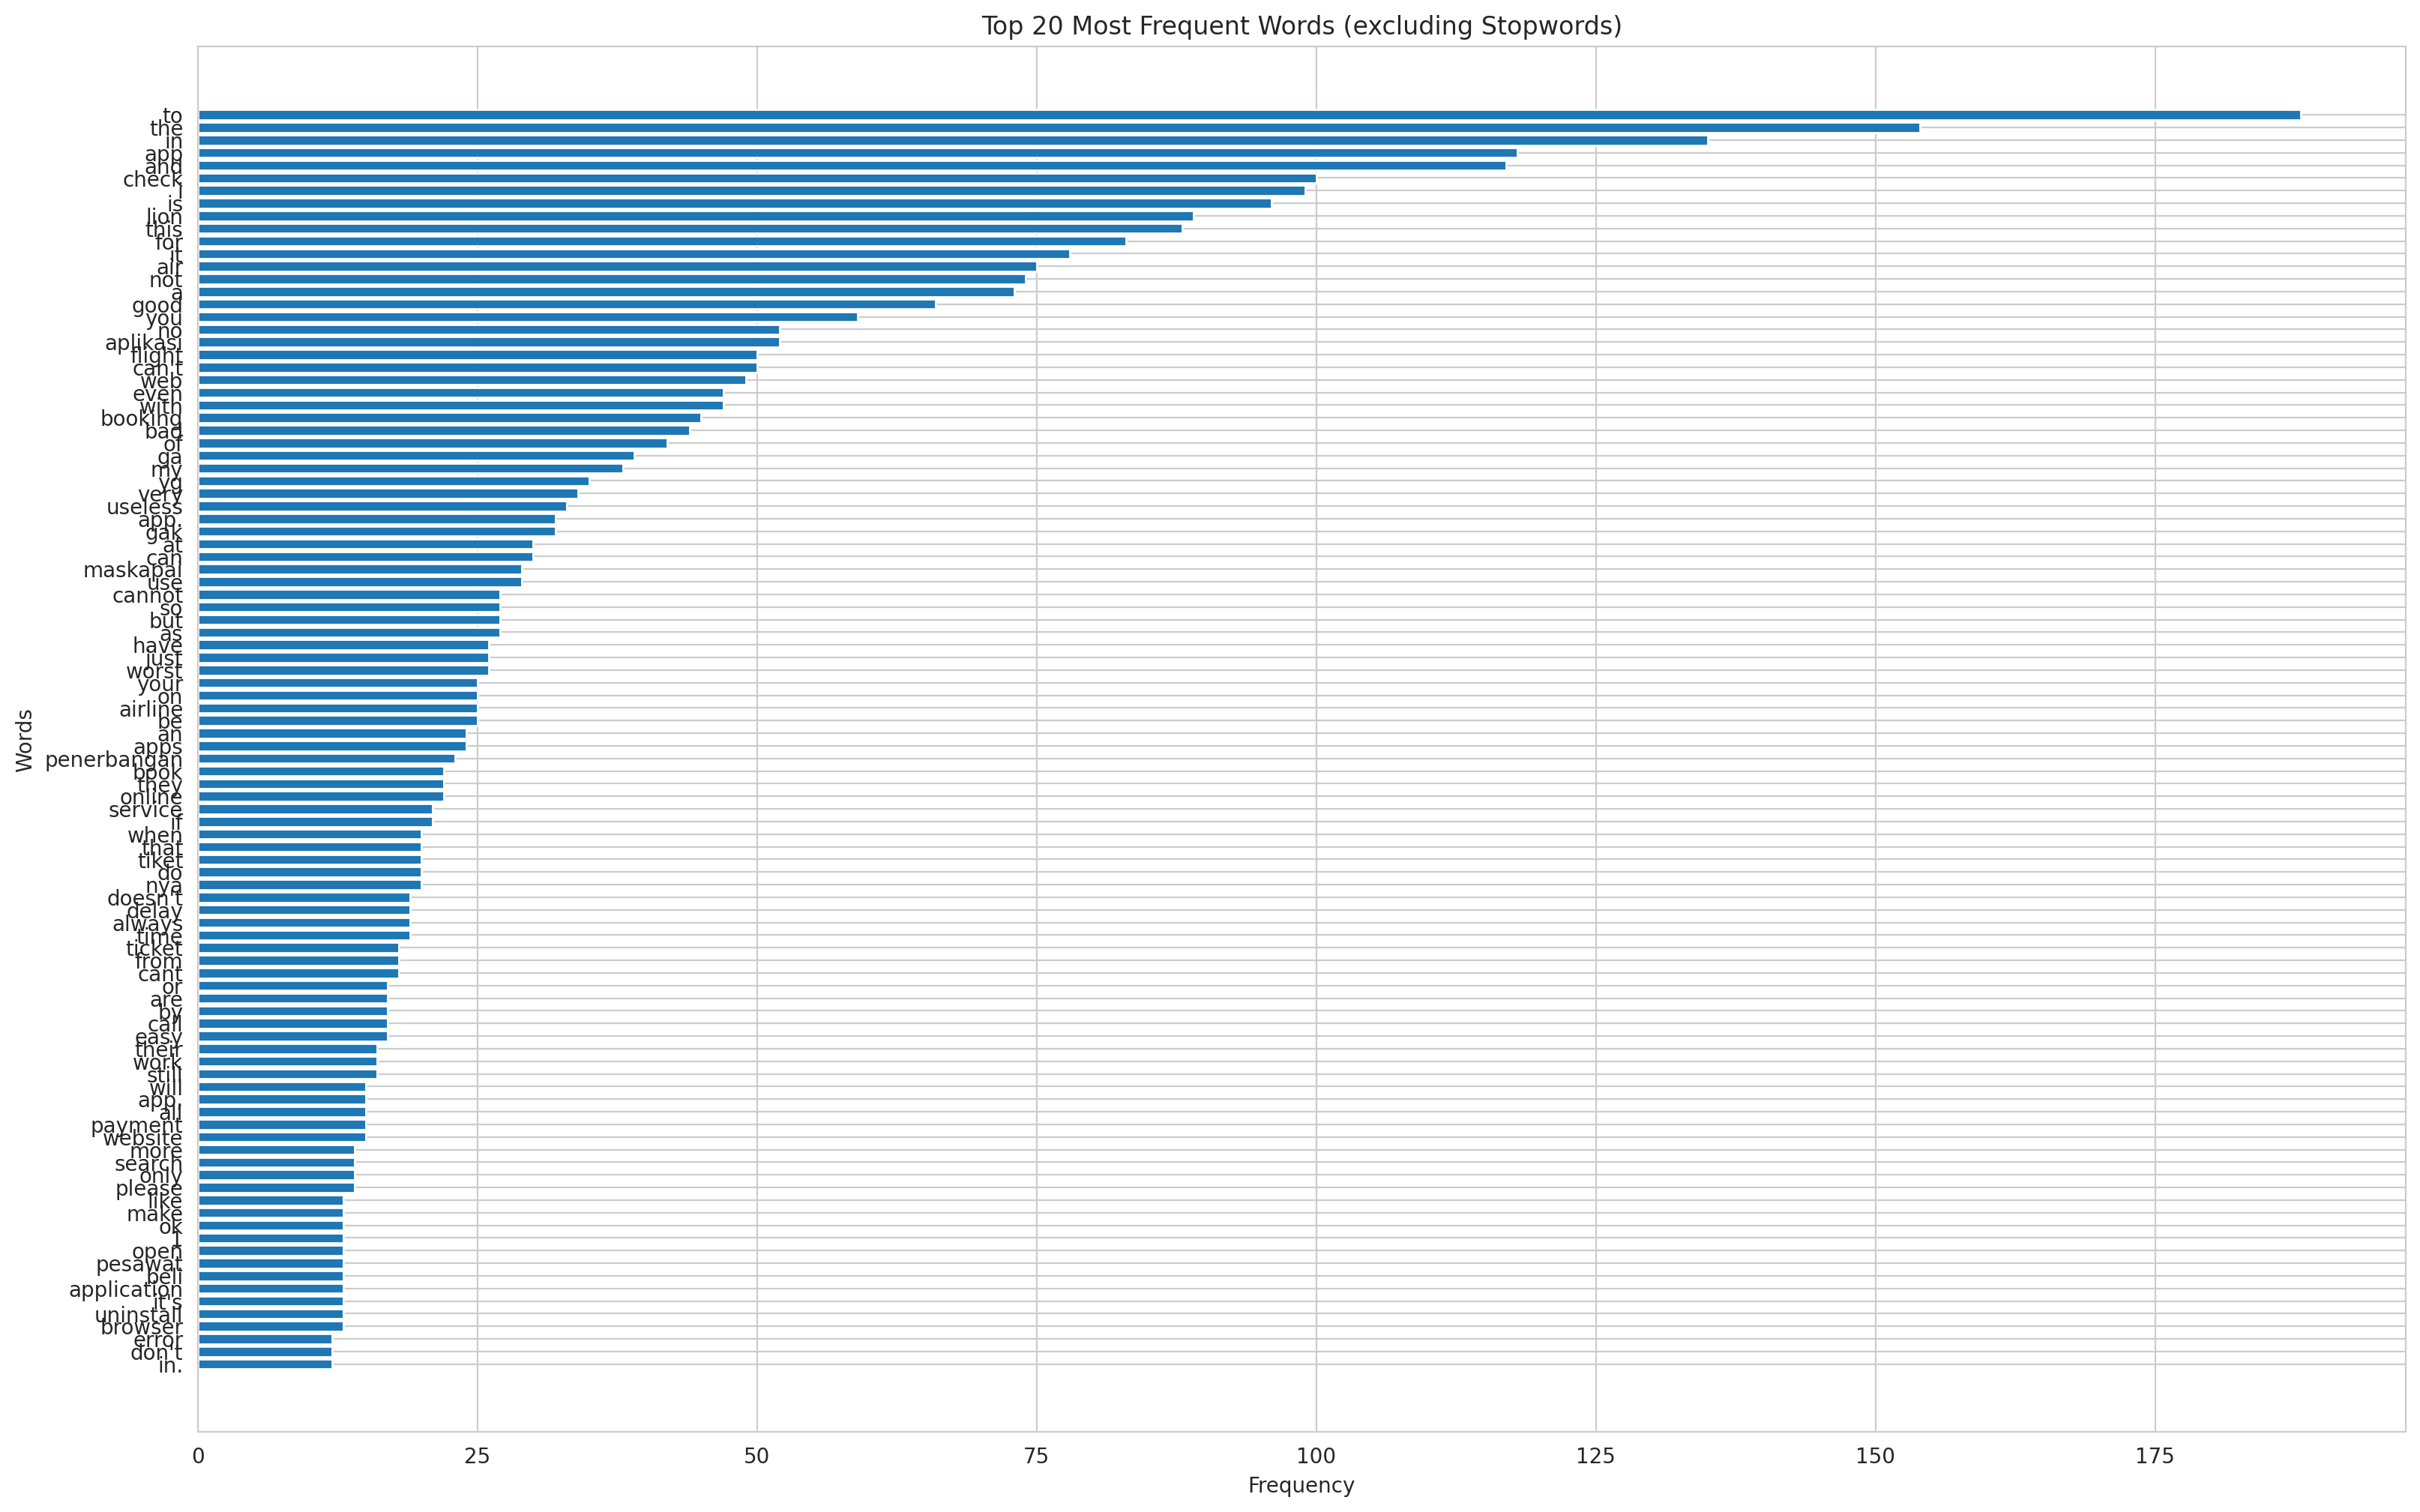

In [ ]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from collections import Counter
import matplotlib.pyplot as plt

# Assuming the text column is named 'text', update accordingly
text_column = 'content'  # Change this if the column has a different name

# Combine all text data into one string
all_text = ' '.join(df_mtrev[text_column].dropna().astype(str))

# Tokenize words and remove stopwords
words = all_text.split()
filtered_words = [word.lower() for word in words if word.lower() not in indonesian_stopwords]

# Count frequent words
word_counts = Counter(filtered_words)
common_words = word_counts.most_common(100)

# Convert to DataFrame for better visualization
word_freq_df = pd.DataFrame(common_words, columns=['Word', 'Frequency'])

# Display the most common words
display(word_freq_df)

# Plot the frequent words
plt.figure(figsize=(19, 12))
plt.barh(word_freq_df['Word'][::-1], word_freq_df['Frequency'][::-1])
plt.xlabel("Frequency")
plt.ylabel("Words")
plt.title("Top 20 Most Frequent Words (excluding Stopwords)")
plt.show()

In [ ]:
#edited from https://www.tensorscience.com/nlp/sentiment-analysis-tutorial-in-python-classifying-reviews-on-movies-and-products
import string

df_mtrev['wordCount'] = [len(review.split()) for review in df_mtrev['content']]
df_mtrev['uppercaseCharCount'] = [sum(char.isupper() for char in review) \
                              for review in df_mtrev['content']]
df_mtrev['specialCharCount'] = [sum(char in string.punctuation for char in review) \
                            for review in df_mtrev['content']]

In [ ]:
df_mtrev.loc[:,["content","score","sentiment_polarity", "sentiment_subjective","wordCount","uppercaseCharCount","specialCharCount"]]

,content,score,sentiment_polarity,sentiment_subjective,wordCount,uppercaseCharCount,specialCharCount
0,constantly error when trying to book ticket via app,1,0.000000,0.333333,9,0,0
1,nice,5,0.600000,1.000000,1,0,0
2,i cannot enter the existing booking in the app. cannot create an account.,1,0.000000,0.000000,13,0,2
3,so poor app,1,-0.400000,0.600000,3,0,0
4,i have book flight why crate paravlom,5,0.000000,0.000000,7,0,0
...,...,...,...,...,...,...,...
793,good enough,4,0.350000,0.550000,2,0,0
794,excellent ! friendly user,5,0.687500,0.750000,4,0,1
795,coolll,5,0.000000,0.000000,1,0,0
796,"maaf sebelumnya... saya pelaggan setia lion air, aplikasi ini memangbcukup membantu dalam pesan ticket lion air.. cuma yang membuat saya kecewa adalah ketika pesan ticket dari tujuan tertentu ke t...",1,0.000000,0.000000,78,0,13


In [ ]:
#Add a column name polarity_rating from changing the score of the review into 3 labels: Pos, Negative Neutral
df_mtrev['sentiment_rating'] = df_mtrev['score'].apply(lambda x: 'Positive' if x > 3 else('Neutral' if x == 3  else 'Negative'))

In [ ]:
df_mtrev.loc[:,["content","score","sentiment_polarity", "sentiment_subjective","sentiment_rating"]]

,content,score,sentiment_polarity,sentiment_subjective,sentiment_rating
0,constantly error when trying to book ticket via app,1,0.000000,0.333333,Negative
1,nice,5,0.600000,1.000000,Positive
2,i cannot enter the existing booking in the app. cannot create an account.,1,0.000000,0.000000,Negative
3,so poor app,1,-0.400000,0.600000,Negative
4,i have book flight why crate paravlom,5,0.000000,0.000000,Positive
...,...,...,...,...,...
793,good enough,4,0.350000,0.550000,Positive
794,excellent ! friendly user,5,0.687500,0.750000,Positive
795,coolll,5,0.000000,0.000000,Positive
796,"maaf sebelumnya... saya pelaggan setia lion air, aplikasi ini memangbcukup membantu dalam pesan ticket lion air.. cuma yang membuat saya kecewa adalah ketika pesan ticket dari tujuan tertentu ke t...",1,0.000000,0.000000,Negative


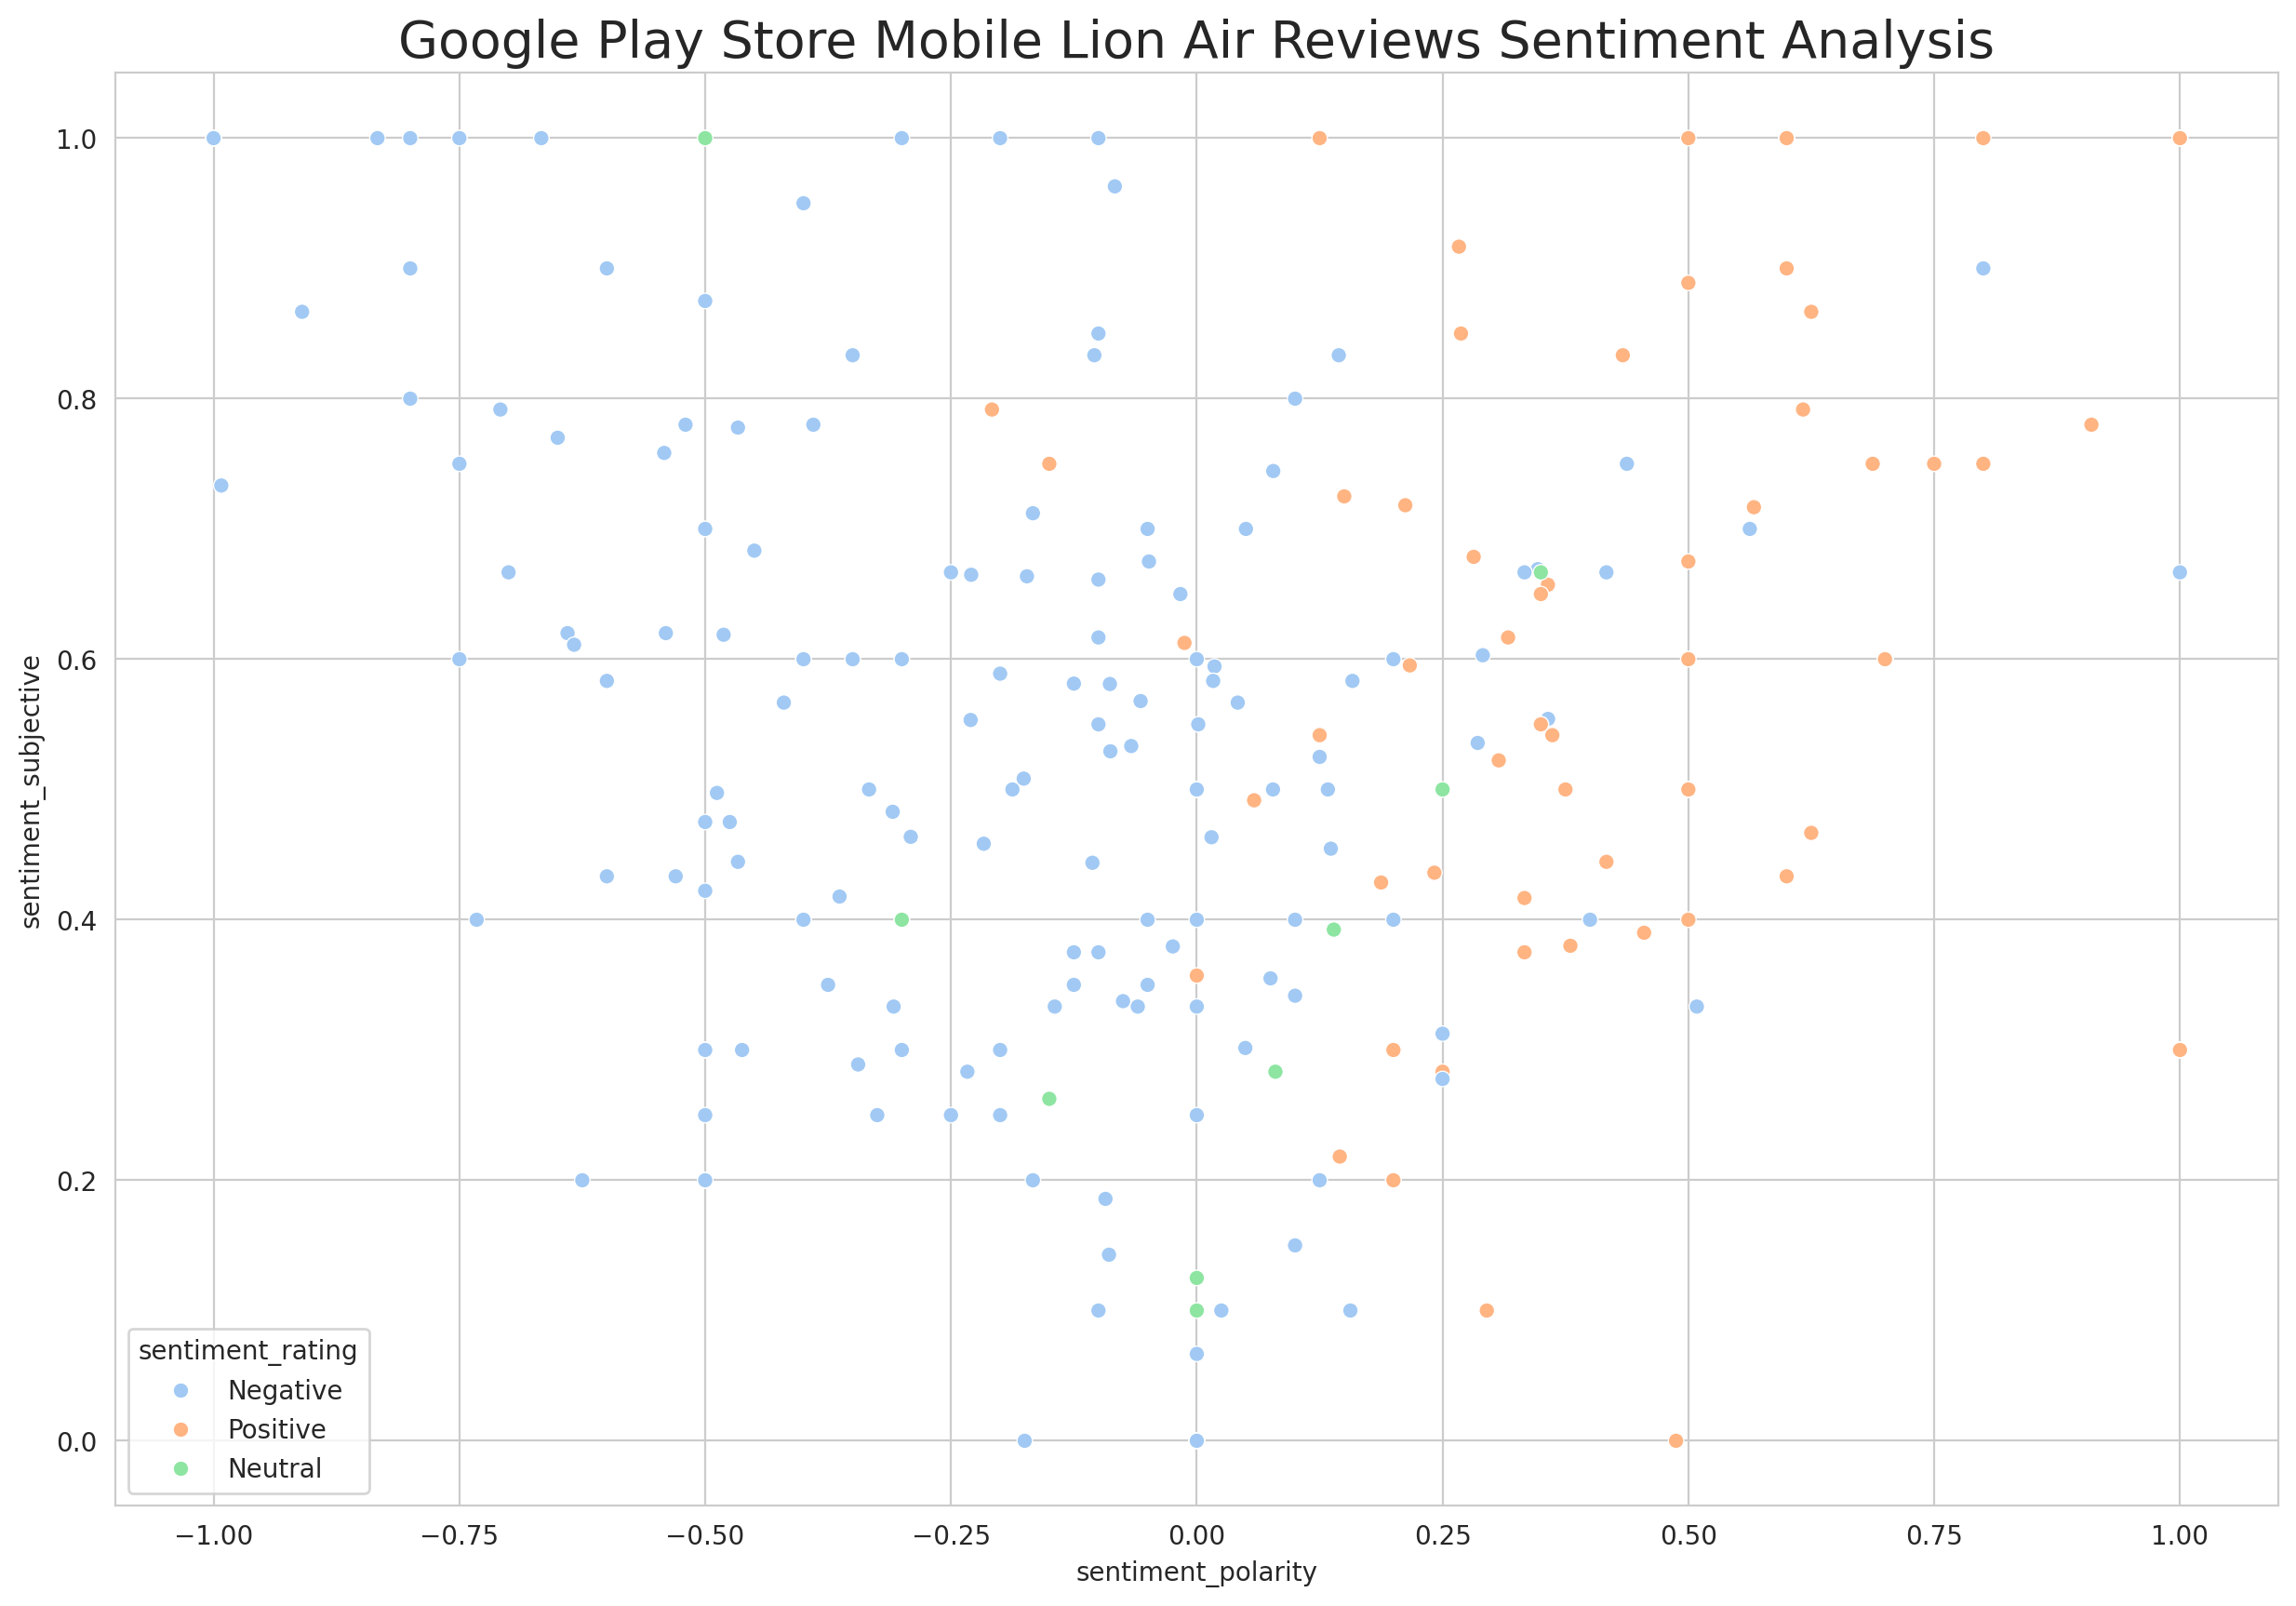

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(15, 10))
# Specify x and y using the 'x' and 'y' parameters within sns.scatterplot
sns.scatterplot(x=df_mtrev['sentiment_polarity'], y=df_mtrev['sentiment_subjective'],
                hue=df_mtrev['sentiment_rating'], edgecolor='white', palette="pastel")
plt.title("Google Play Store Mobile Lion Air Reviews Sentiment Analysis", fontsize=20)
plt.show()

In [ ]:
# function to plot most frequent terms
def freq_words(x, terms = 30):
  all_words = ' '.join([text for text in x])
  all_words = all_words.split()
  #Import FreqDist from nltk.probability
  from nltk.probability import FreqDist
  fdist = FreqDist(all_words)
  words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})

  # selecting top 20 most frequent words
  d = words_df.nlargest(columns="count", n = terms)
  plt.figure(figsize=(20,5))
  # Use the 'rainbow' colormap for the bar plot
  ax = sns.barplot(data=d, x= "word", y = "count", palette="rainbow")
  ax.set(ylabel = 'Count')
  plt.show()

/tmp/ipython-input-2152088084.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=d, x= "word", y = "count", palette="rainbow")


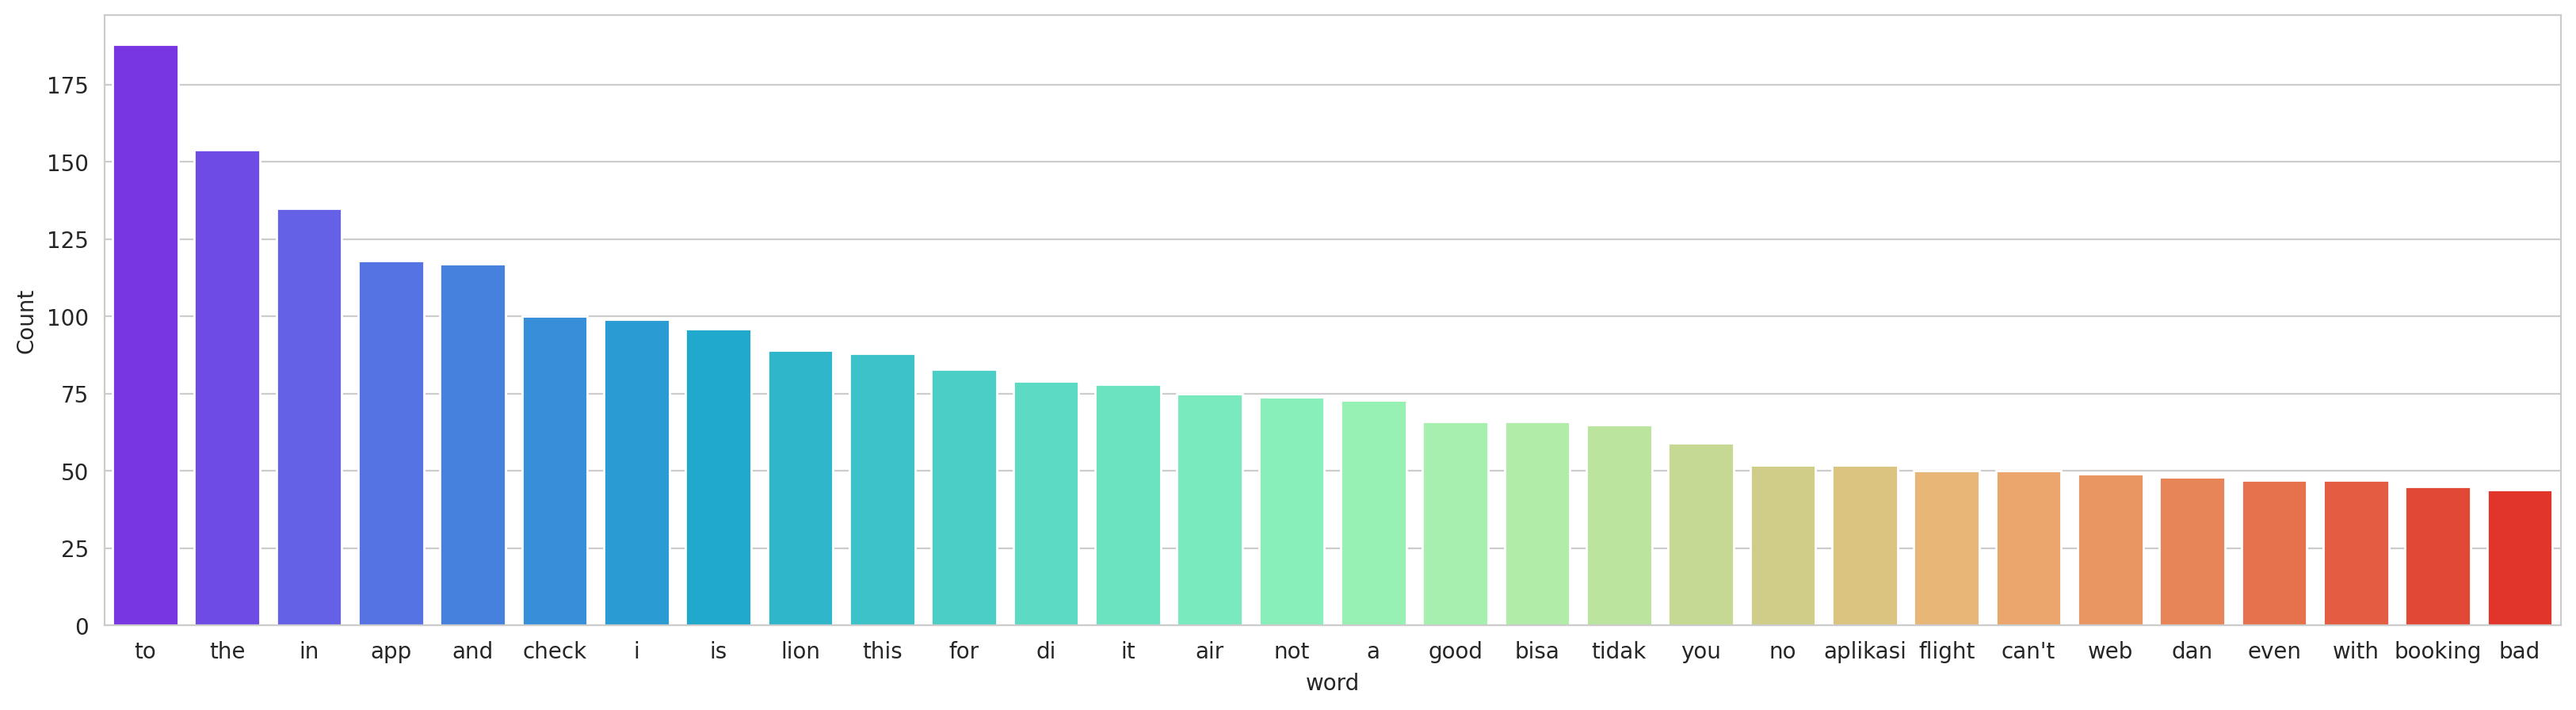

In [ ]:
freq_words(df_mtrev['content'])

In [ ]:
# prompt: the [content] column hasnt been applied Indonesian stopwords removal using Sastrawi

!pip install Sastrawi

from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

# Create stopword remover
factory = StopWordRemoverFactory()
stopword_remover = factory.create_stop_word_remover()

# Apply stopword removal to the 'content' column
df_mtrev['content'] = df_mtrev['content'].apply(lambda x: stopword_remover.remove(x))


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 3.1 MB/s eta 0:00:00


In [ ]:
# prompt: can you also apply English stopwords as well to the [content] column

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

# Get English stopwords
english_stopwords = stopwords.words('english')

# Assuming df_jknrev is your DataFrame and 'content' is the column
df_mtrev['content'] = df_mtrev['content'].apply(lambda x: ' '.join([word for word in x.split() if word not in english_stopwords]))


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
len(english_stopwords)

198

In [ ]:
english_stopwords[-1]   # karena indeks mulai dari 0

"you've"

In [ ]:
df_mtrev.loc[:,["content","score","sentiment_polarity", "sentiment_subjective","sentiment_rating"]]

,content,score,sentiment_polarity,sentiment_subjective,sentiment_rating
0,constantly error trying book ticket via app,1,0.000000,0.333333,Negative
1,nice,5,0.600000,1.000000,Positive
2,cannot enter existing booking app. cannot create account.,1,0.000000,0.000000,Negative
3,poor app,1,-0.400000,0.600000,Negative
4,book flight crate paravlom,5,0.000000,0.000000,Positive
...,...,...,...,...,...
793,good enough,4,0.350000,0.550000,Positive
794,excellent ! friendly user,5,0.687500,0.750000,Positive
795,coolll,5,0.000000,0.000000,Positive
796,"maaf sebelumnya... pelaggan setia lion air, aplikasi memangbcukup membantu pesan ticket lion air.. cuma membuat kecewa ketika pesan ticket tujuan tertentu tujuan tertentu itu multitrip haru 2x boo...",1,0.000000,0.000000,Negative


In [ ]:
stop_words = set(stopwords.words('english'))

def clean_text(text):
    # lowercase
    text = text.lower()
    # hapus tanda baca
    text = re.sub(r'[^\w\s]', '', text)
    # hapus stopwords
    words = [word for word in text.split() if word not in stop_words]
    return ' '.join(words)

# terapkan ke dataframe
df_mtrev['review_after_stopwords'] = df_mtrev['content'].apply(clean_text)


/tmp/ipython-input-2152088084.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=d, x= "word", y = "count", palette="rainbow")


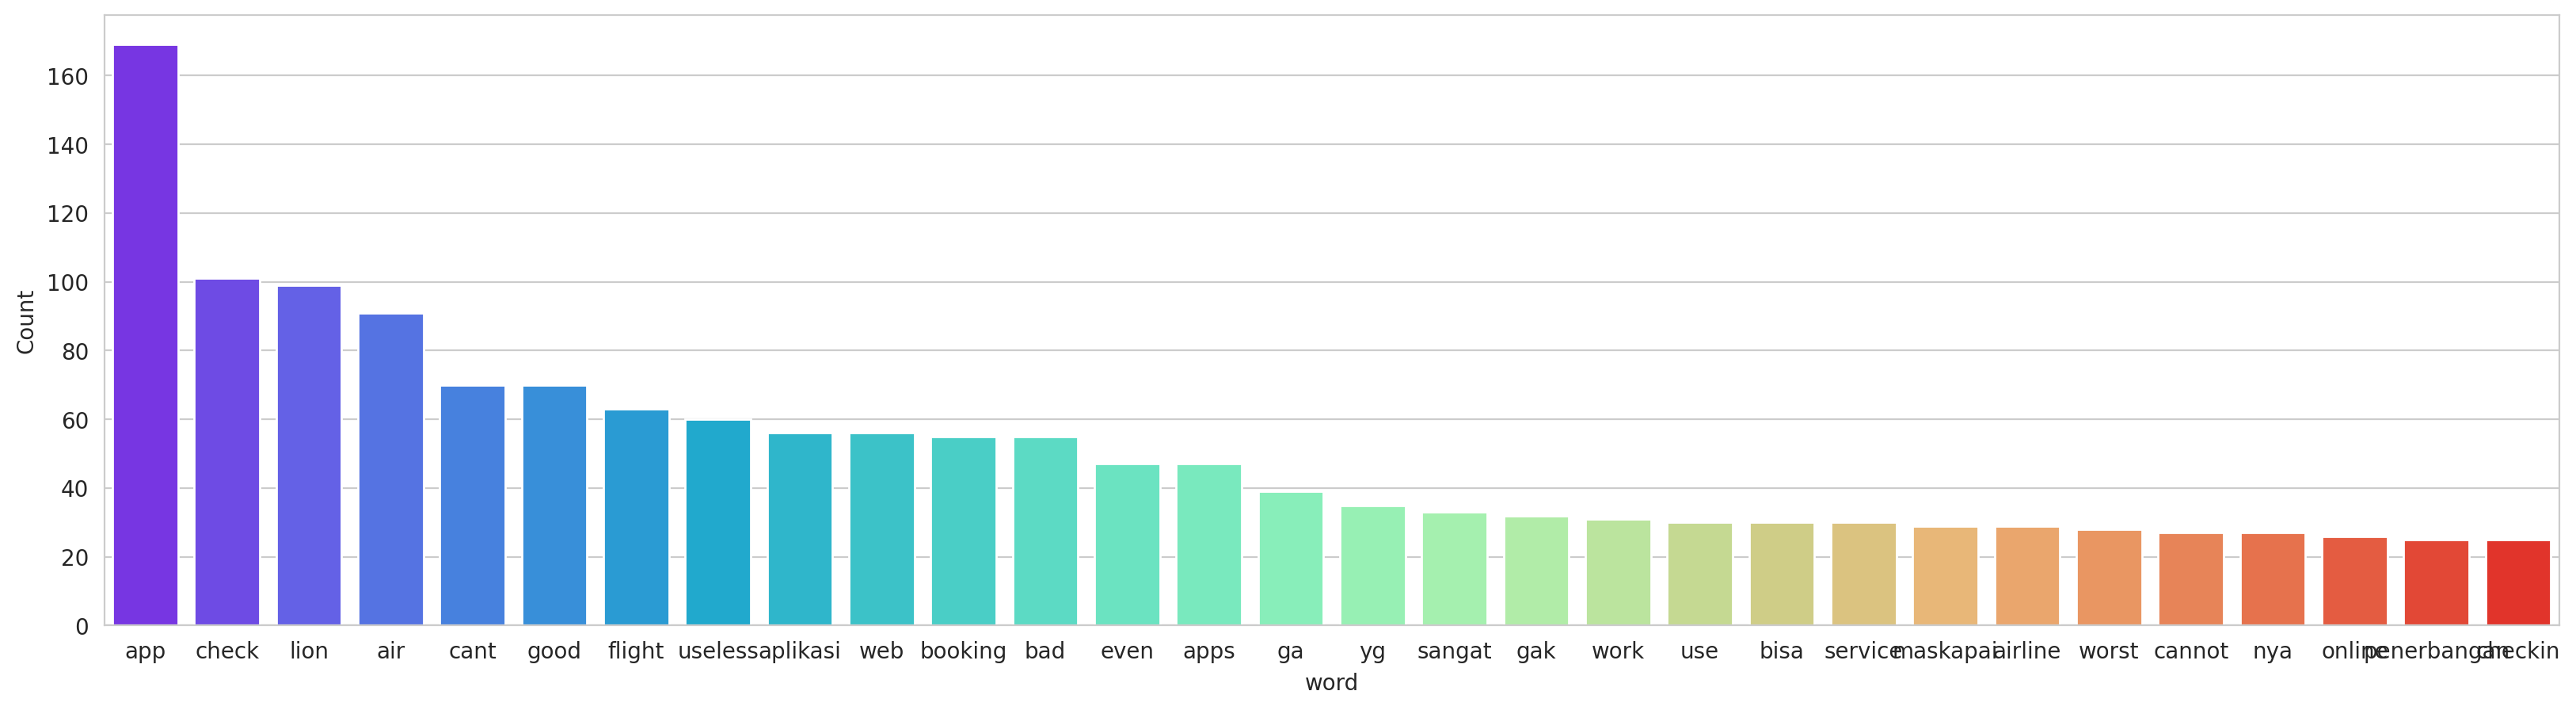

In [ ]:
freq_words(df_mtrev['review_after_stopwords'])

In [ ]:
#Count after stopwords
#edited from https://www.tensorscience.com/nlp/sentiment-analysis-tutorial-in-python-classifying-reviews-on-movies-and-products
import string

df_mtrev['wordCount'] = [len(review.split()) for review in df_mtrev['content']]
df_mtrev['wordCount_after_stopwords'] = [len(review.split()) for review in df_mtrev['review_after_stopwords']]


In [ ]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

# Stopwords English
stop_words_eng = set(stopwords.words('english'))

# Stopwords Indonesia tambahan
stop_words_id = {
    "yg","yang","ga","gak","ngga","nggak","tidak","bukan","aja","kok","sih",
    "deh","nih","dong","kan","lah","pun","saja","sangat","amat","sekali",
    "itu","ini","dan","atau","ke","di","dari","untuk","pada","dengan","nya",
    "good","useless","bad","even","work","use","worst","service","book","always",
    "delay","booking","time","delay","I","call","easy","chat","word","install","flights",
    "please","application","cant","airline","apps","web","app","payment","reschedule","like",
    "aplikasinya","like","1","uninstall","search","still","make","customer","open","make",
    "working","option","flight","ever","2","never","center","get"
}

# Gabungan stopwords
stop_words = stop_words_eng.union(stop_words_id)

def clean_text(text):
    # lowercase
    text = text.lower()
    # hapus tanda baca tapi biarkan kata dipisah
    text = re.sub(r'[^\w\s]', ' ', text)
    # tokenize
    tokens = word_tokenize(text)
    # hapus stopwords
    filtered = [word for word in tokens if word not in stop_words]
    return ' '.join(filtered)

# Terapkan ke dataframe
df_mtrev['review_after_stopwords'] = df_mtrev['content'].apply(clean_text)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


/tmp/ipython-input-2152088084.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=d, x= "word", y = "count", palette="rainbow")


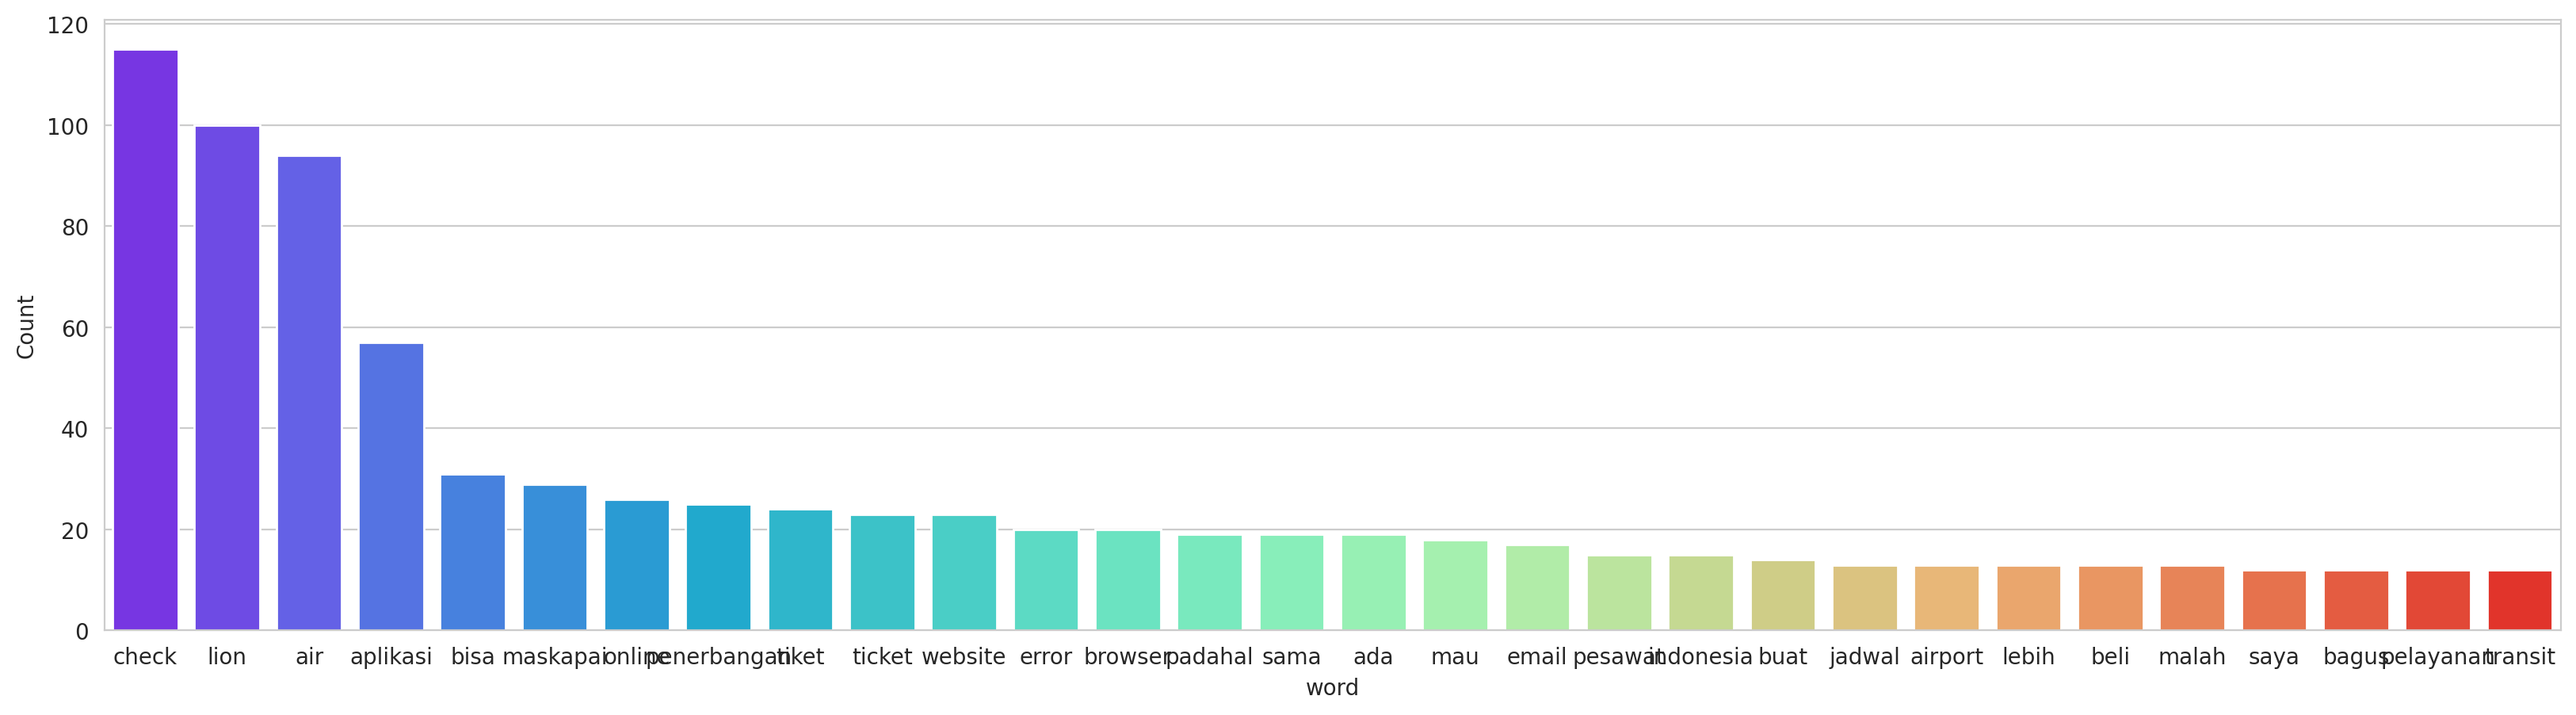

In [ ]:
freq_words(df_mtrev['review_after_stopwords'])

,Word,Frequency
0,app,118
1,check,100
2,lion,89
3,air,75
4,good,66
...,...,...
95,fly,9
96,jam,9
97,great,9
98,better,9


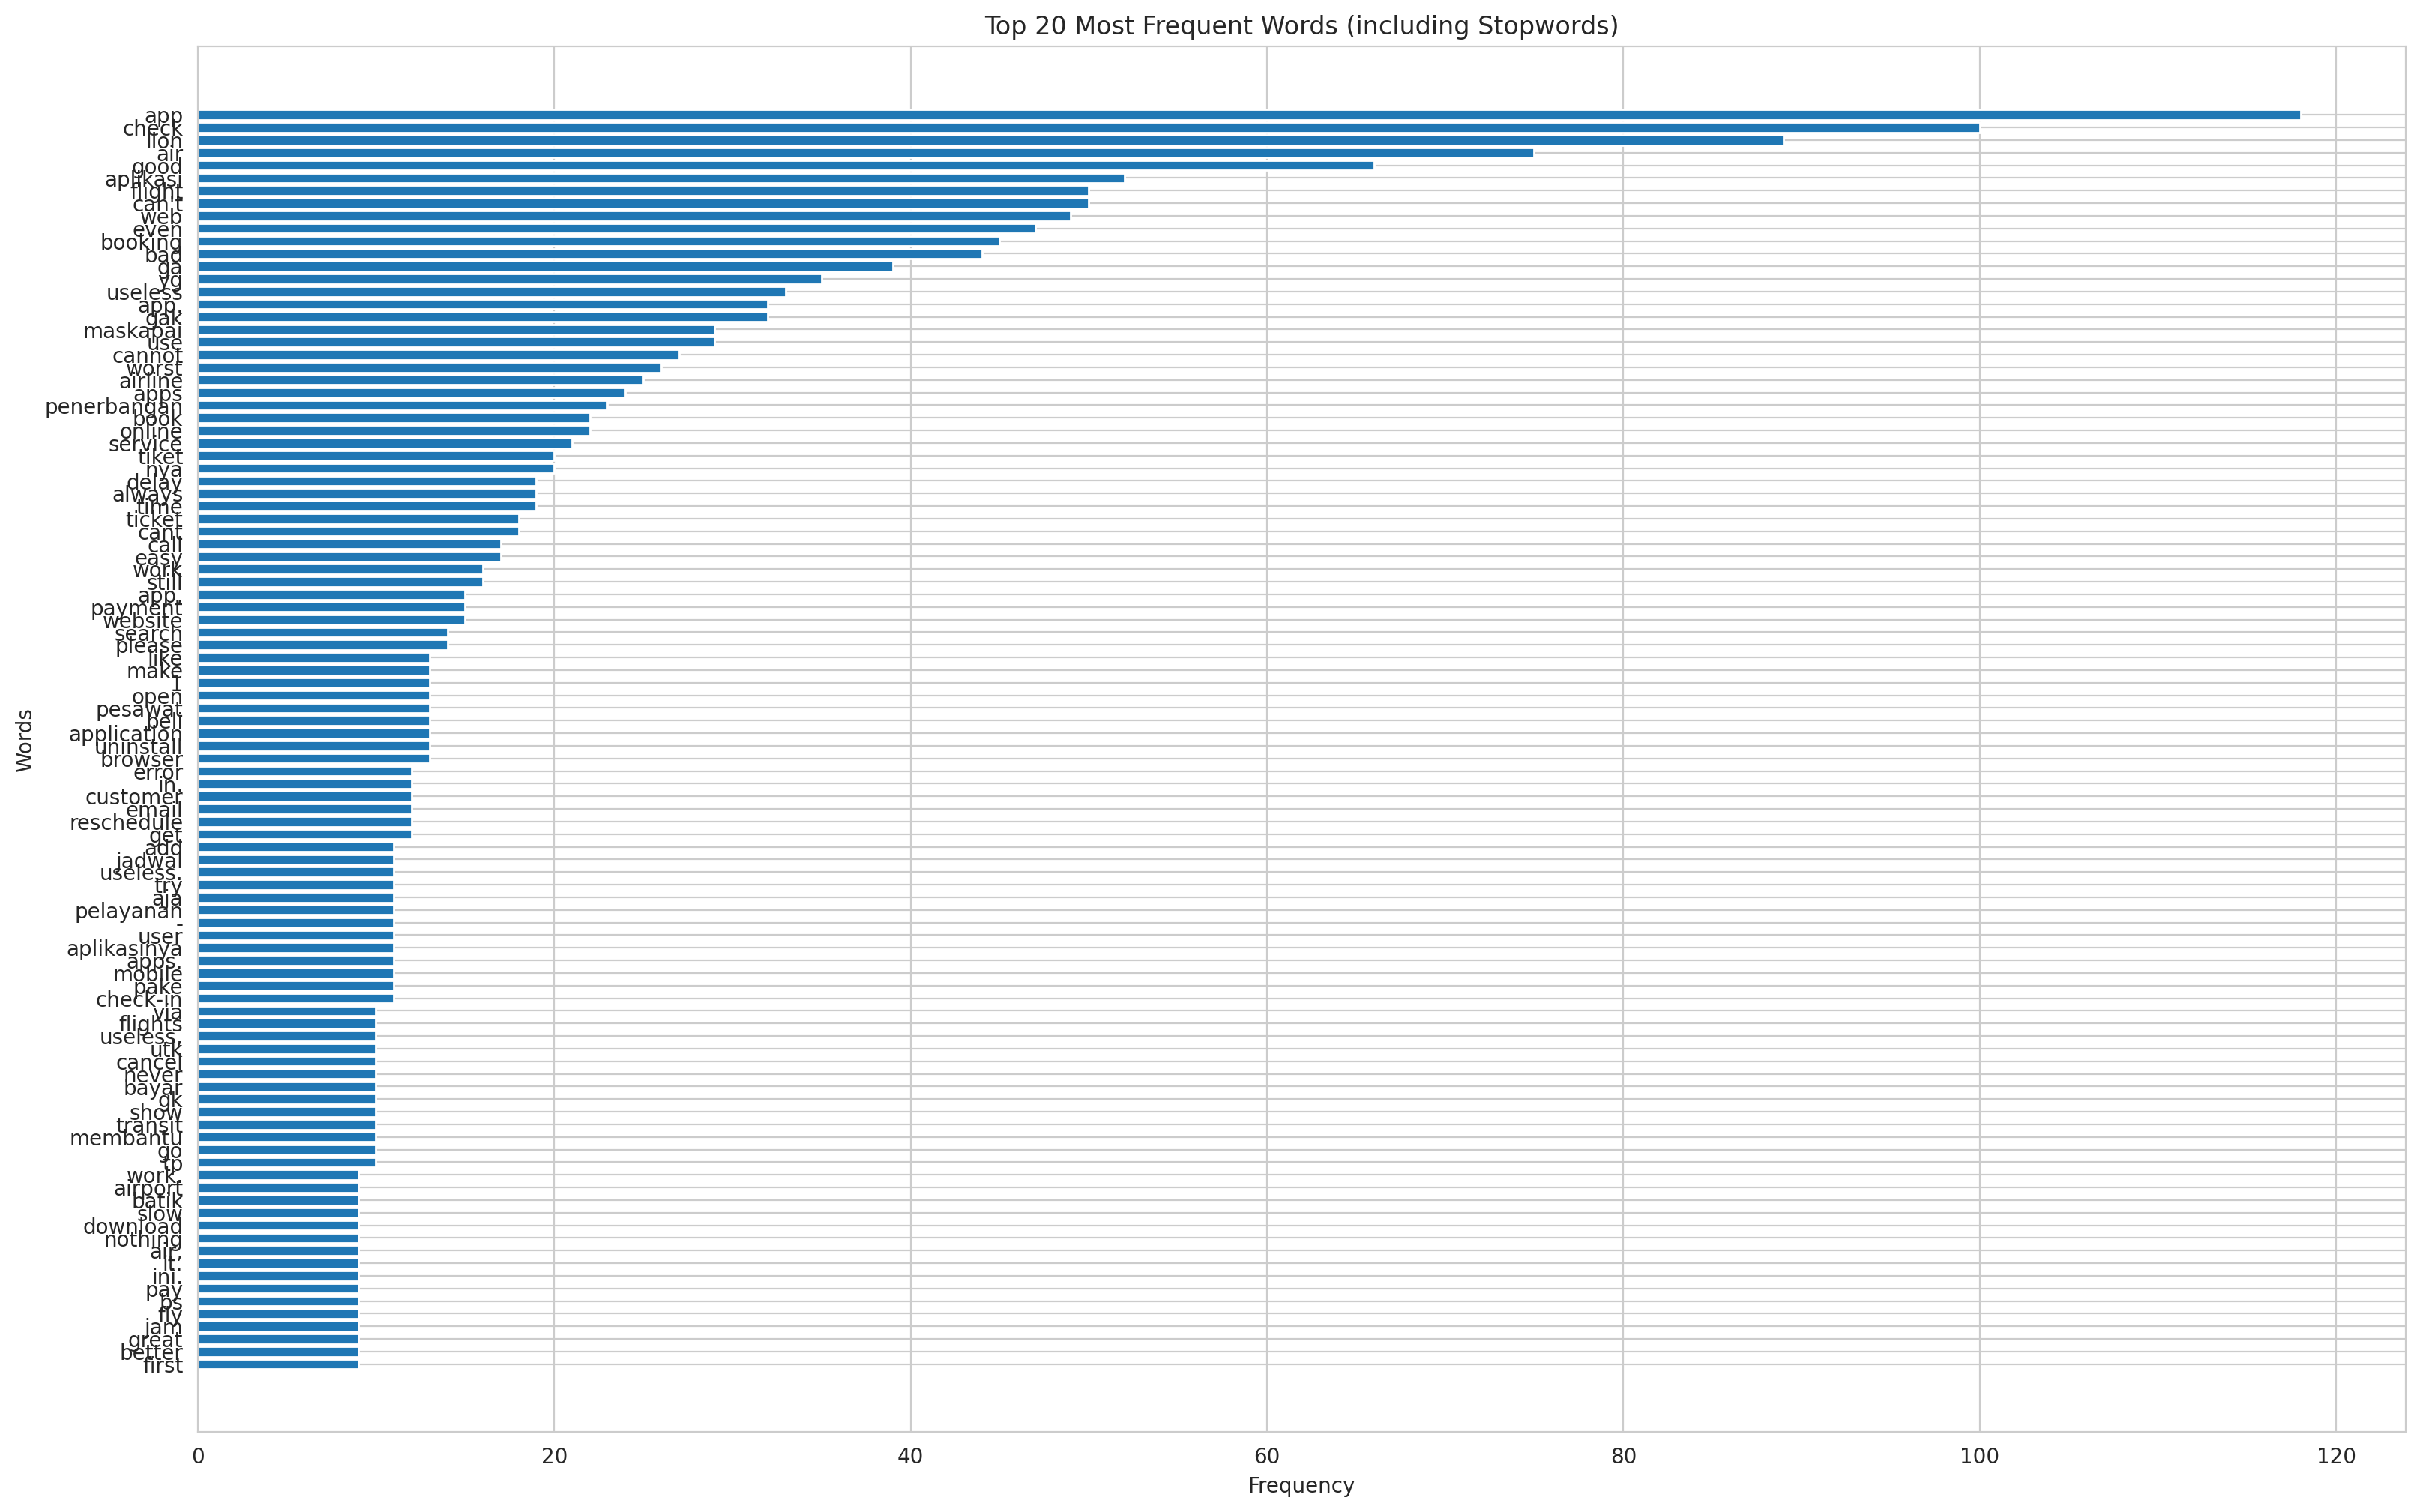

In [ ]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from collections import Counter
import matplotlib.pyplot as plt

# Assuming the text column is named 'text', update accordingly
text_column = 'content'  # Change this if the column has a different name

# Combine all text data into one string
all_text = ' '.join(df_mtrev[text_column].dropna().astype(str))

# Tokenize words and remove stopwords
words = all_text.split()
filtered_words = [word.lower() for word in words if word.lower() not in indonesian_stopwords]

# Count frequent words
word_counts = Counter(filtered_words)
common_words = word_counts.most_common(100)

# Convert to DataFrame for better visualization
word_freq_df = pd.DataFrame(common_words, columns=['Word', 'Frequency'])

# Display the most common words
display(word_freq_df)

# Plot the frequent words
plt.figure(figsize=(19, 12))
plt.barh(word_freq_df['Word'][::-1], word_freq_df['Frequency'][::-1])
plt.xlabel("Frequency")
plt.ylabel("Words")
plt.title("Top 20 Most Frequent Words (including Stopwords)")
plt.show()

#BoW bag of Words


# Step 1: Tokenize the data, remove stop words and perform stemming or lemmatization.

In [ ]:
import nltk
# Download the 'stopwords' dataset
nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('wordnet')

from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import re
paragraph = "The news mentioned here is fake. Audience do not encourage fake news. Fake news is false or misleading"
sentences = nltk.sent_tokenize(paragraph)
lemmatizer = WordNetLemmatizer()
corpus = []
for i in range(len(sentences)):
    # The following lines were not indented properly
    sent = re.sub('[^a-zA-Z]', ' ', sentences[i])
    sent = sent.lower()
    sent= sent.split()
    sent = [lemmatizer.lemmatize(word) for word in sent if not word in set(stopwords.words('english'))]
    sent = ' '.join(sent)
    corpus.append(sent)
print(corpus)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...


['news mentioned fake', 'audience encourage fake news', 'fake news false misleading']


# Step 2: List all unique words

In [ ]:
print("Corpus:", corpus)

Corpus: ['news mentioned fake', 'audience encourage fake news', 'fake news false misleading']


In [ ]:
# Finding unique words
all_words = []
for sentence in corpus:
    for word in sentence.split():
        all_words.append(word)

unique_words = list(set(all_words))
print("Unique words:", unique_words)

Unique words: ['misleading', 'mentioned', 'false', 'encourage', 'fake', 'news', 'audience']


#Step 3: Create a dictionary with mapping of words to a number. This should now be sorted on frequency of occurrence in descending order.

Finding unique words and their frequencies

In [ ]:
from collections import Counter

all_words = []
for sentence in corpus:
    for word in sentence.split():
        all_words.append(word)

word_frequencies = Counter(all_words)

# Print the word counts
print("Word Frequencies:", word_frequencies)

# Sorting words by frequency (descending)
sorted_words = sorted(word_frequencies.items(), key=lambda item: item[1], reverse=True)

# Creating the dictionary mapping words to numbers
word_to_number = {}
for i, (word, frequency) in enumerate(sorted_words):
    word_to_number[word] = i + 1  # Assign numbers starting from 1

print("Word to Number Mapping (Sorted by Frequency):", word_to_number)


Word Frequencies: Counter({'news': 3, 'fake': 3, 'mentioned': 1, 'audience': 1, 'encourage': 1, 'false': 1, 'misleading': 1})
Word to Number Mapping (Sorted by Frequency): {'news': 1, 'fake': 2, 'mentioned': 3, 'audience': 4, 'encourage': 5, 'false': 6, 'misleading': 7}


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer()
independentFeatures = cv.fit_transform(corpus).toarray()
independentFeatures

array([[0, 0, 1, 0, 1, 0, 1],
       [1, 1, 1, 0, 0, 0, 1],
       [0, 0, 1, 1, 0, 1, 1]])

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score

# 1. Ambil teks dan label
X = df_mtrev['content']               # teks asli
# X = df_mtrev['review_after_stopwords']  # kalau mau pakai teks yang sudah diproses
y = df_mtrev['sentiment_rating']      # label sentimen (0/1)

# 2. Ubah teks jadi BoW
cv = CountVectorizer()
X_bow = cv.fit_transform(X).toarray()

# 3. Split data (latih & uji)
X_train, X_test, y_train, y_test = train_test_split(
    X_bow, y, test_size=0.2, random_state=42
)

# 4. Latih model
model = MultinomialNB()
model.fit(X_train, y_train)

# 5. Evaluasi
y_pred = model.predict(X_test)
print("Akurasi:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# 6. Prediksi review baru
contoh_review = ["this app is amazing", "worst app ever, waste of time"]
X_new = cv.transform(contoh_review).toarray()
print("Prediksi:", model.predict(X_new))  # Output 1=positif, 0=negatif


Akurasi: 0.7625
              precision    recall  f1-score   support

    Negative       0.82      0.89      0.85       101
     Neutral       0.00      0.00      0.00         9
    Positive       0.68      0.64      0.66        50

    accuracy                           0.76       160
   macro avg       0.50      0.51      0.50       160
weighted avg       0.73      0.76      0.74       160

Prediksi: ['Negative' 'Negative']


In [ ]:
print(df_mtrev.columns)


Index(['reviewId', 'userName', 'userImage', 'content', 'score',
       'thumbsUpCount', 'reviewCreatedVersion', 'at', 'replyContent',
       'repliedAt', 'appVersion', 'sentiment_polarity', 'sentiment_subjective',
       'wordCount', 'uppercaseCharCount', 'specialCharCount',
       'sentiment_rating', 'review_after_stopwords',
       'wordCount_after_stopwords'],
      dtype='object')


# Exploratory Data Analysis (EDA) of JKN Reviews

## 1. Install Necessary Packages
This section ensures that all required Python packages are installed before running the notebook.
```python
!pip install pandas matplotlib seaborn nltk
```

In [ ]:
!pip install pandas matplotlib seaborn nltk

## 2. Import Required Libraries

---


We import essential libraries for data analysis, visualization, and text processing.
```python
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import nltk
import string
```

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import nltk
import string

## 3. Download Stopwords
Downloading the Indonesian stopwords from NLTK for text processing.
```python
nltk.download('stopwords')
from nltk.corpus import stopwords
```

In [ ]:
nltk.download('stopwords')
from nltk.corpus import stopwords

# Install library Sastrawi
!pip install Sastrawi

# Import library
import re
import nltk
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from nltk.stem import WordNetLemmatizer

# Download resource NLTK
nltk.download('wordnet')
nltk.download('omw-1.4')

# Buat objek stemmer dan lemmatizer
factory = StemmerFactory()
stemmer = factory.create_stemmer()
lemmatizer = WordNetLemmatizer()

# Fungsi cleaning
def clean_text(text):
    # Case lowering
    text = text.lower()

    # Hapus tanda baca
    text = re.sub(r'[^\w\s]', '', text)

    # Stemming (bahasa Indonesia)
    text = stemmer.stem(text)

    # Lemmatization (bahasa Inggris)
    words = text.split()
    lemmatized_words = [lemmatizer.lemmatize(word, 'v') for word in words]
    text = ' '.join(lemmatized_words)

    return text

# Terapkan fungsi cleaning pada kolom 'content'
df_mtrev['cleaned_review'] = df_mtrev['content'].apply(clean_text)

# Tampilkan beberapa baris pertama
print(df_mtrev[['content', 'cleaned_review']].head())

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


                                                     content  \
0                constantly error trying book ticket via app   
1                                                       nice   
2  cannot enter existing booking app. cannot create account.   
3                                                   poor app   
4                                 book flight crate paravlom   

                                      cleaned_review  
0           constantly error try book ticket via app  
1                                               nice  
2  cannot enter exist book app cannot create account  
3                                           poor app  
4                         book flight crate paravlom  


## 5. Data Overview
This section provides basic dataset information, including column names, data types, and the first few records.
```python
# Convert 'at' column to datetime format
df_mtrev['at'] = pd.to_datetime(df_mtrev['at'])

# Display dataset info and first few rows
df_mtrev.info()
df_mtrev.head()
```

In [ ]:
# Convert 'at' column to datetime format
df_mtrev['at'] = pd.to_datetime(df_mtrev['at'])

# Display dataset info and first few rows
df_mtrev.info()
df_mtrev.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 798 entries, 0 to 797
Data columns (total 20 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   reviewId                   798 non-null    object        
 1   userName                   798 non-null    object        
 2   userImage                  798 non-null    object        
 3   content                    798 non-null    object        
 4   score                      798 non-null    int64         
 5   thumbsUpCount              798 non-null    int64         
 6   reviewCreatedVersion       631 non-null    object        
 7   at                         798 non-null    datetime64[ns]
 8   replyContent               196 non-null    object        
 9   repliedAt                  196 non-null    datetime64[ns]
 10  appVersion                 631 non-null    object        
 11  sentiment_polarity         798 non-null    float64       
 12  sentimen

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion,sentiment_polarity,sentiment_subjective,wordCount,uppercaseCharCount,specialCharCount,sentiment_rating,review_after_stopwords,wordCount_after_stopwords,cleaned_review
0,557dde96-5a4b-4ebf-9b67-74cfb24e7bcc,Ruslan Seniuk,https://play-lh.googleusercontent.com/a/ACg8ocLMuL8m7XH85FsfErAh8okO4tbWHQbrrjol3KRsBtN5lUT_=mo,constantly error trying book ticket via app,1,0,4.7,2025-09-20 14:06:57,None,NaT,4.7,0.0,0.333333,7,0,0,Negative,constantly error trying ticket via,7,constantly error try book ticket via app
1,55405e67-3a24-4c6d-9bce-714f6b2c5fd5,candra yulianto,https://play-lh.googleusercontent.com/a-/ALV-UjXFCIJ9EjGKDdbQFsHWTqF9VDzTQYnm8ZY_S78fXflb_Fs_qbeg,nice,5,0,4.7,2025-09-13 09:16:32,None,NaT,4.7,0.6,1.000000,1,0,0,Positive,nice,1,nice
2,282cb0a2-449e-43c0-b91e-aa57821786a5,Vikrant Minhas,https://play-lh.googleusercontent.com/a-/ALV-UjXIpriRgBVyEiaZHhPmIFvd80NYr9DJZSFQhUziRh62vK3NW6o,cannot enter existing booking app. cannot create account.,1,0,4.7,2025-08-28 02:15:16,None,NaT,4.7,0.0,0.000000,8,0,2,Negative,enter existing create account,8,cannot enter exist book app cannot create account
3,863f6723-077c-4186-94f7-5f7e80bd2b81,alizan aziz,https://play-lh.googleusercontent.com/a-/ALV-UjWd26QQO-cydwHdUHK-ersqar774WXPX20XWNuykE5vdpA_svY4,poor app,1,0,4.7,2025-08-26 04:10:02,None,NaT,4.7,-0.4,0.600000,2,0,0,Negative,poor,2,poor app
4,176e22eb-3b93-49ae-97e6-ed57b3a55bca,Devinder Singh,https://play-lh.googleusercontent.com/a-/ALV-UjXlRDMOoT-kBoxYR7uHIjch-QEKaxVo6gIr0D4VSd0GwYgPxHVy,book flight crate paravlom,5,0,4.7,2025-08-18 13:25:45,None,NaT,4.7,0.0,0.000000,4,0,0,Positive,crate paravlom,4,book flight crate paravlom


## 6. Missing Values Analysis
Identifies and counts missing values in each column.
```python
missing_values = df_mtrev.isnull().sum()
print("Missing Values Summary:")
print(missing_values)
```

In [ ]:
missing_values = df_mtrev.isnull().sum()
print("Missing Values Summary:")
print(missing_values)

Missing Values Summary:
reviewId                       0
userName                       0
userImage                      0
content                        0
score                          0
thumbsUpCount                  0
reviewCreatedVersion         167
at                             0
replyContent                 602
repliedAt                    602
appVersion                   167
sentiment_polarity             0
sentiment_subjective           0
wordCount                      0
uppercaseCharCount             0
specialCharCount               0
sentiment_rating               0
review_after_stopwords         0
wordCount_after_stopwords      0
cleaned_review                 0
dtype: int64


## 7. Review Score Distribution
Visualizing the distribution of review scores to understand user sentiments.
```python
plt.figure(figsize=(8,5))
sns.countplot(x=df_mtrev['score'], palette="viridis")
plt.title("Distribution of Review Scores")
plt.xlabel("Review Score")
plt.ylabel("Count")
plt.show()
```

/tmp/ipython-input-2062186506.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df_mtrev['score'], palette="viridis")


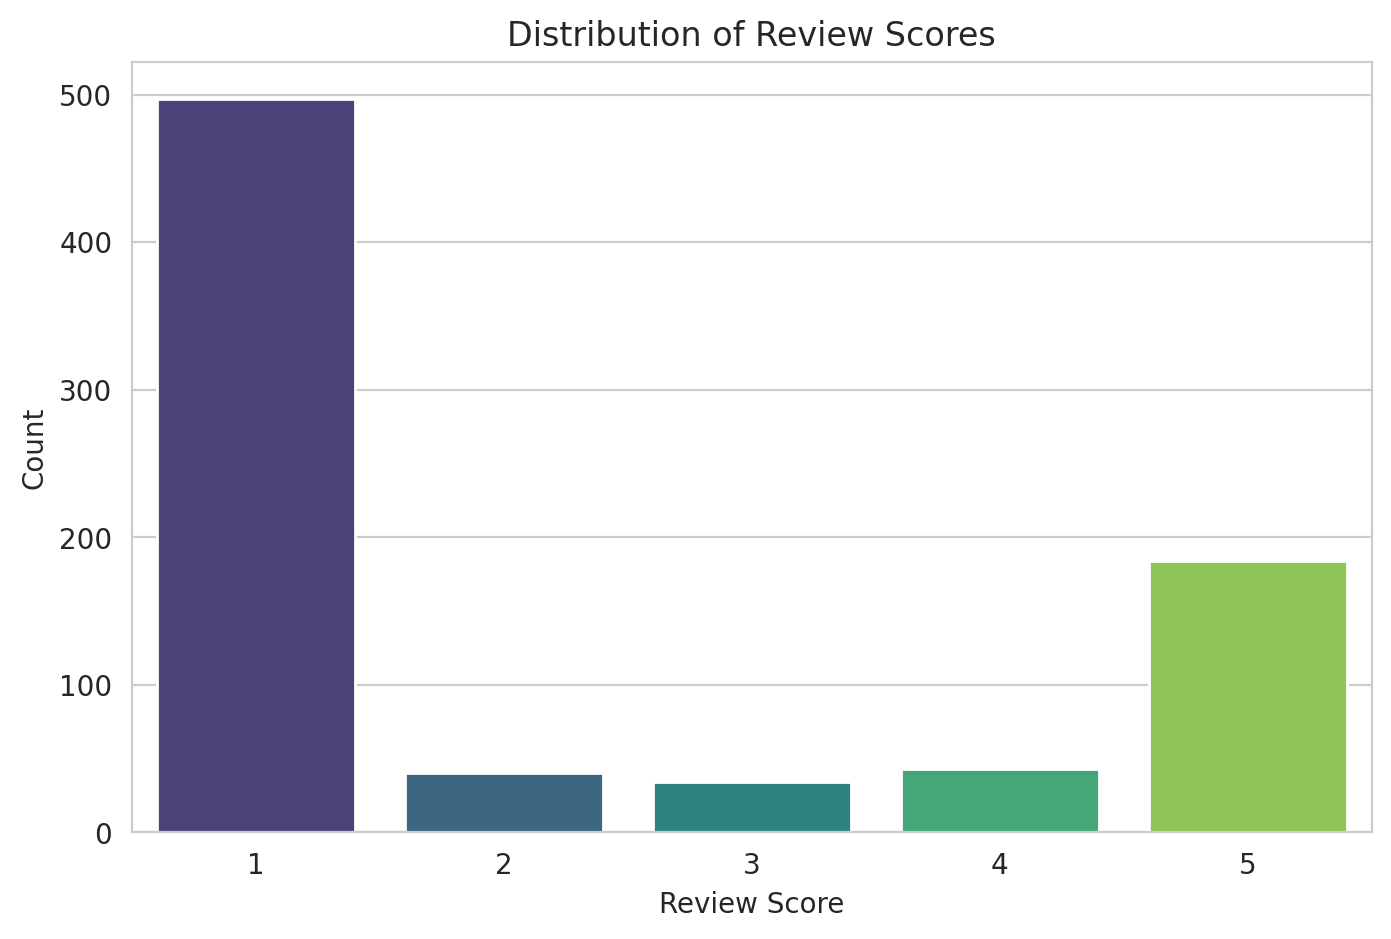

In [ ]:
plt.figure(figsize=(8,5))
sns.countplot(x=df_mtrev['score'], palette="viridis")
plt.title("Distribution of Review Scores")
plt.xlabel("Review Score")
plt.ylabel("Count")
plt.show()

## 8. Review Trends Over Time
Analyzing how the number of reviews changes over time to detect patterns.
```python
# Extract review date
df_mtrev['review_date'] = df_mtrev['at'].dt.date
review_trend = df_jknrev.groupby('review_date').size()

plt.figure(figsize=(12, 6))
review_trend.plot()
plt.title("Daily Review Counts Over Time")
plt.xlabel("Date")
plt.ylabel("Number of Reviews")
plt.grid(True)
plt.show()
```

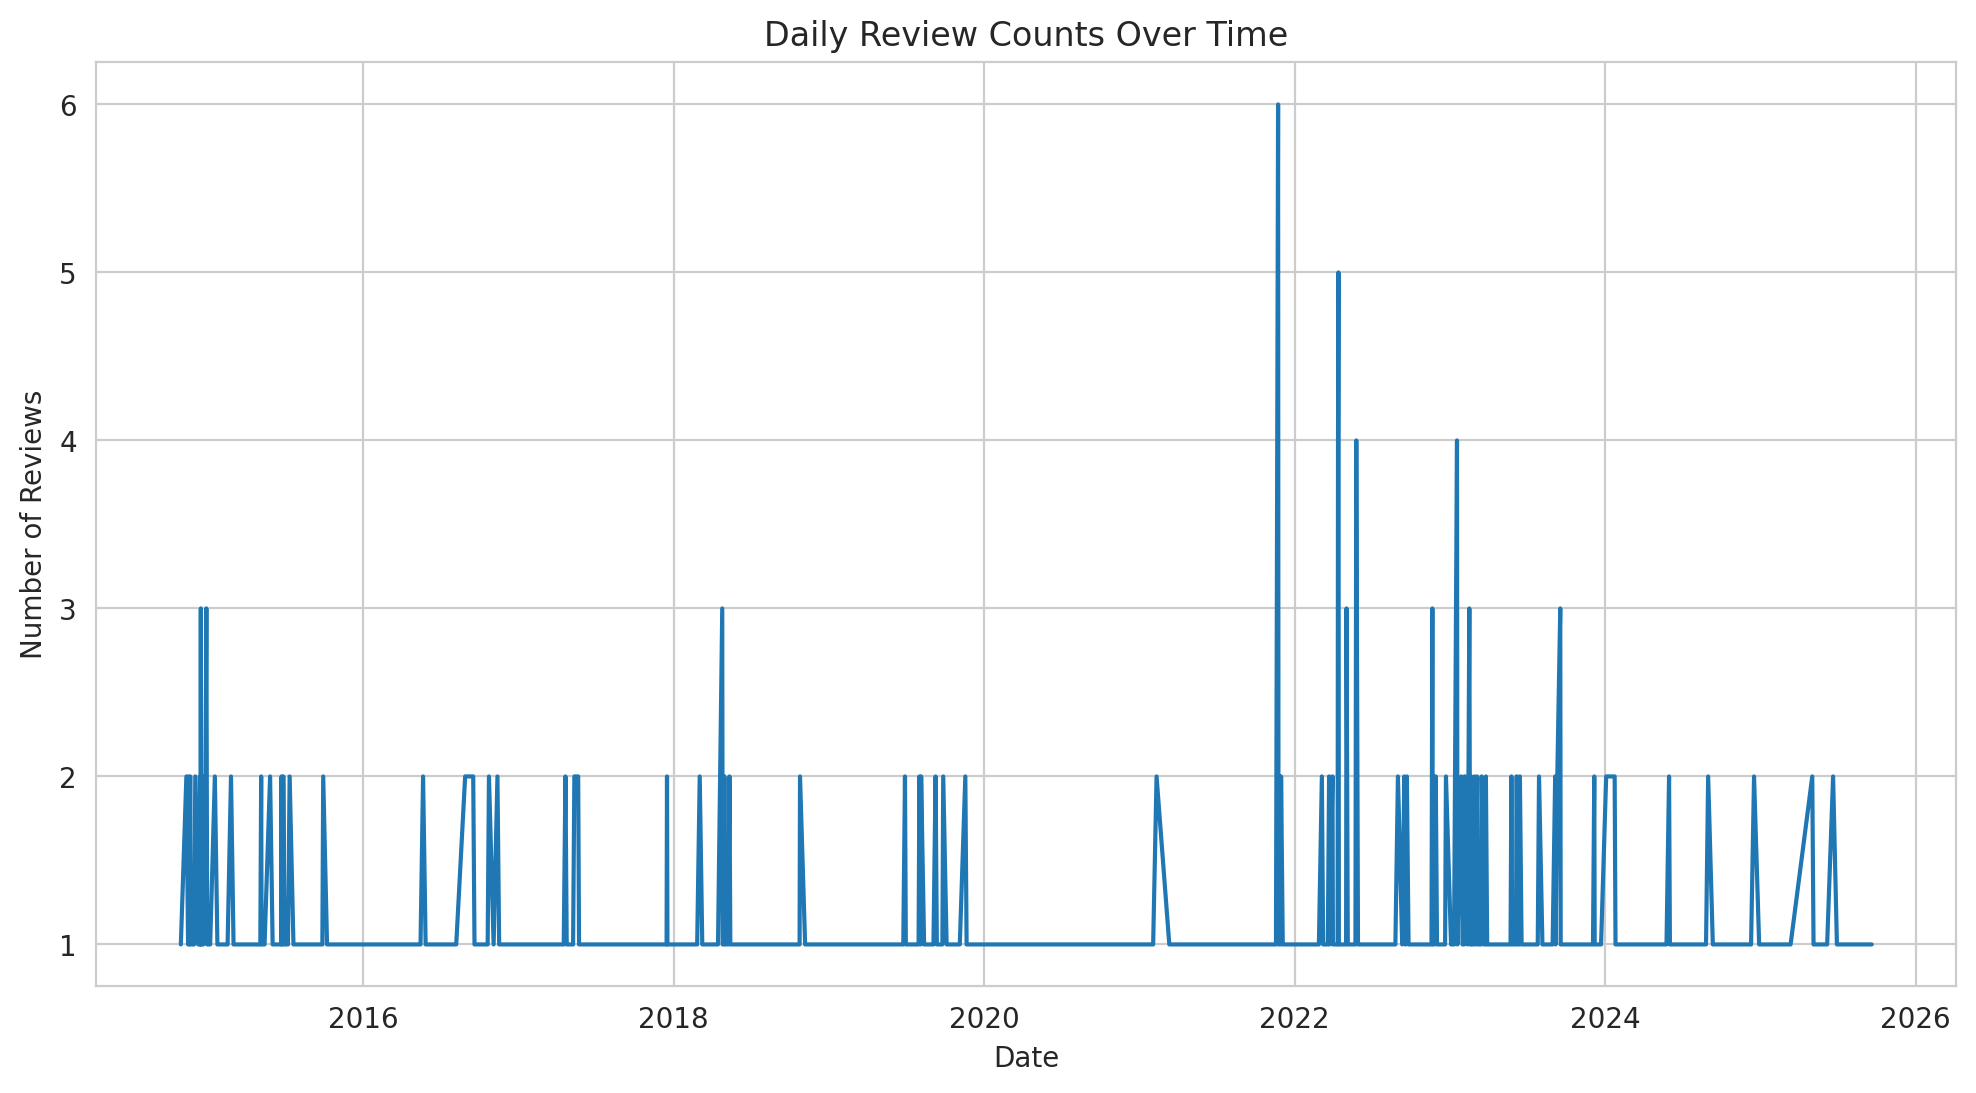

In [ ]:
# Extract review date
df_mtrev['review_date'] = df_mtrev['at'].dt.date
review_trend = df_mtrev.groupby('review_date').size()

plt.figure(figsize=(12, 6))
review_trend.plot()
plt.title("Daily Review Counts Over Time")
plt.xlabel("Date")
plt.ylabel("Number of Reviews")
plt.grid(True)
plt.show()

## 9. Word Frequency Analysis
Analyzing common words in reviews, excluding Indonesian stopwords.
```python
stop_words = set(stopwords.words('indonesian'))

# Combine all review text
all_reviews = " ".join(df_mtrev['content'].dropna()).lower()
all_reviews = all_reviews.translate(str.maketrans("", "", string.punctuation))

# Tokenization and filtering words
words = all_reviews.split()
filtered_words = [word for word in words if word not in stop_words]

# Counting word occurrences
word_counts = Counter(filtered_words)
common_words = pd.DataFrame(word_counts.most_common(20), columns=['Word', 'Frequency'])

# Display most common words
print("Most Common Words in Reviews:")
print(common_words)
```


In [ ]:
stop_words = set(stopwords.words('indonesian'))

# Combine all review text
all_reviews = " ".join(df_mtrev['content'].dropna()).lower()
all_reviews = all_reviews.translate(str.maketrans("", "", string.punctuation))

# Tokenization and filtering words
words = all_reviews.split()
filtered_words = [word for word in words if word not in stop_words]

# Counting word occurrences
word_counts = Counter(filtered_words)
common_words = pd.DataFrame(word_counts.most_common(20), columns=['Word', 'Frequency'])

# Display most common words
print("Most Common Words in Reviews:")
print(common_words)

Most Common Words in Reviews:
        Word  Frequency
0        app        169
1      check        101
2       lion         99
3        air         90
4       cant         70
5       good         70
6     flight         63
7    useless         60
8   aplikasi         56
9        web         56
10   booking         55
11       bad         55
12      even         47
13      apps         47
14        ga         39
15        yg         35
16       gak         32
17      work         31
18       use         30
19   service         30


In [ ]:
from google.colab import files

df_mtrev.to_csv('data_clean.csv', index=False)
files.download('data_clean.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>